## Testing Siamese models

In [13]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import frangi
import tensorflow as tf
from tensorflow.python.client import device_lib

# paths
root = "MOBIUS"
img_root = os.path.join(root, "Images")
resize_to = (512, 512)

print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14569941719102989799
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4488757248
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11226642032680485463
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2025-11-26 17:28:26.835955: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-26 17:28:26.836733: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-26 17:28:26.837156: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [14]:
from tensorflow.keras import layers, models

def conv_block(x, f):
    x = layers.Conv2D(f, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(f, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    return x

def unet_model(input_shape=(128,128,3), n_classes=3):
    inputs = layers.Input(input_shape)
    # Encoder
    c1 = conv_block(inputs, 64); p1 = layers.MaxPool2D()(c1)
    c2 = conv_block(p1, 128);   p2 = layers.MaxPool2D()(c2)
    c3 = conv_block(p2, 256)
    # Decoder
    u2 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c3)
    u2 = layers.Concatenate()([u2, c2])
    c4 = conv_block(u2, 128)
    u1 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c4)
    u1 = layers.Concatenate()([u1, c1])
    c5 = conv_block(u1, 64)
    outputs = layers.Conv2D(n_classes, 1, activation='softmax')(c5)
    return models.Model(inputs, outputs)

model = unet_model()
model.summary()

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 32, 32,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 64, 64,    │    131,200 │ batch_normalizat… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 64, 64,    │          0 │ conv2d_transpose

 Total params: 1,868,099 (7.13 MB)

 Trainable params: 1,865,539 (7.12 MB)

 Non-trainable params: 2,560 (10.00 KB)

✅ Model loaded from Model/sclera_iris_segmentation_model.h5


/tmp/ipykernel_14542/3972342552.py:89: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean_val, std_val = float(mean_val), float(std_val)


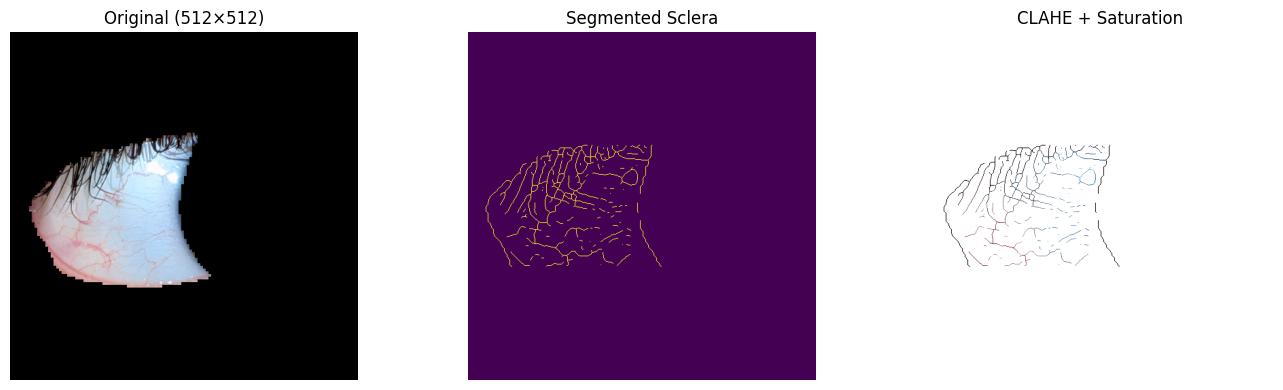

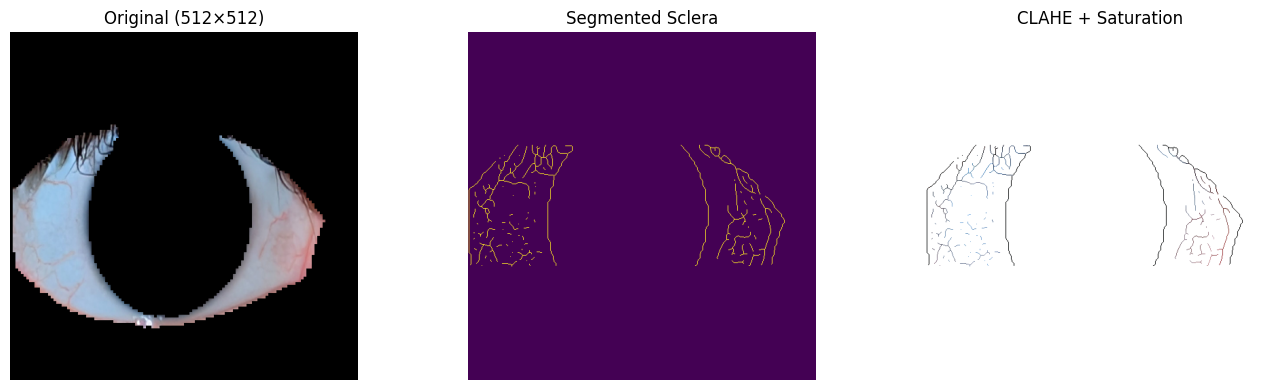

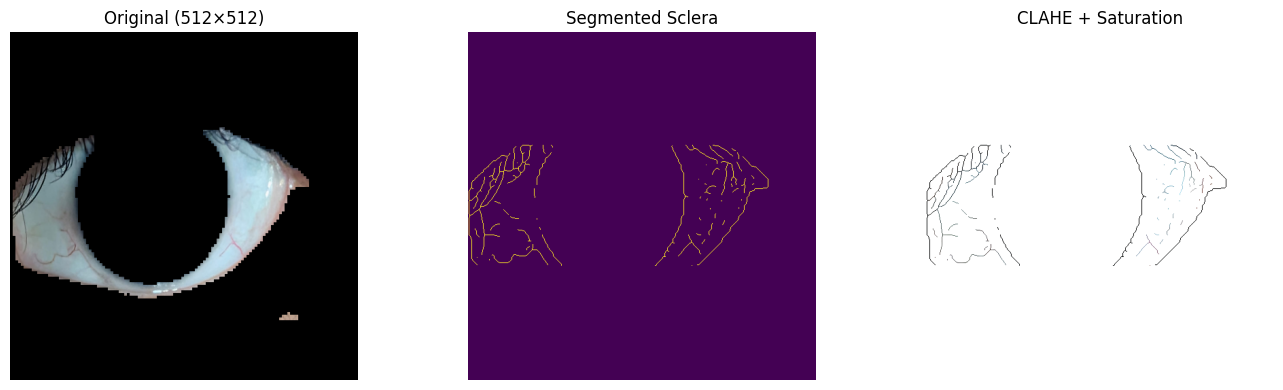

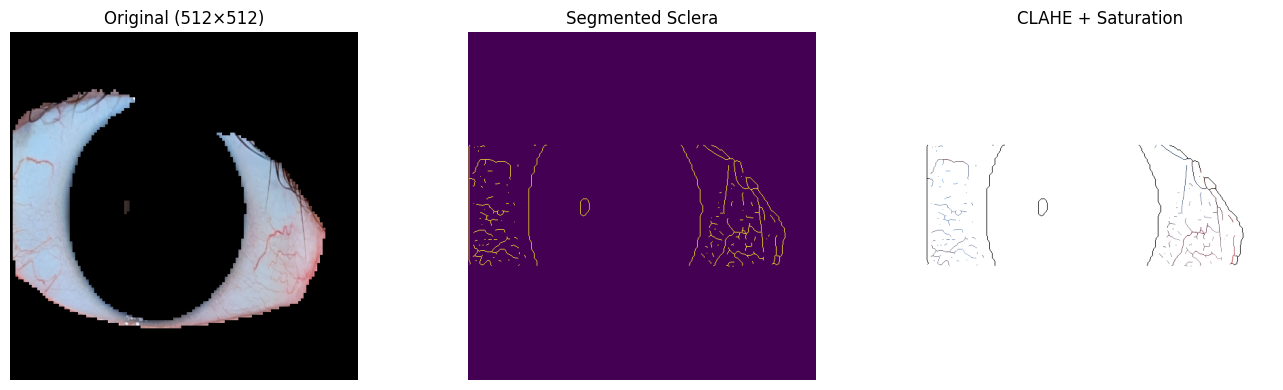

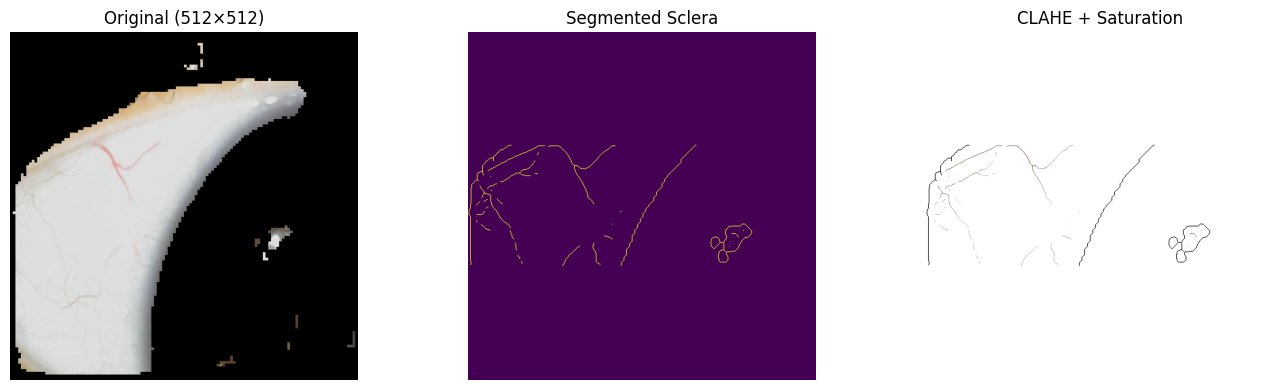

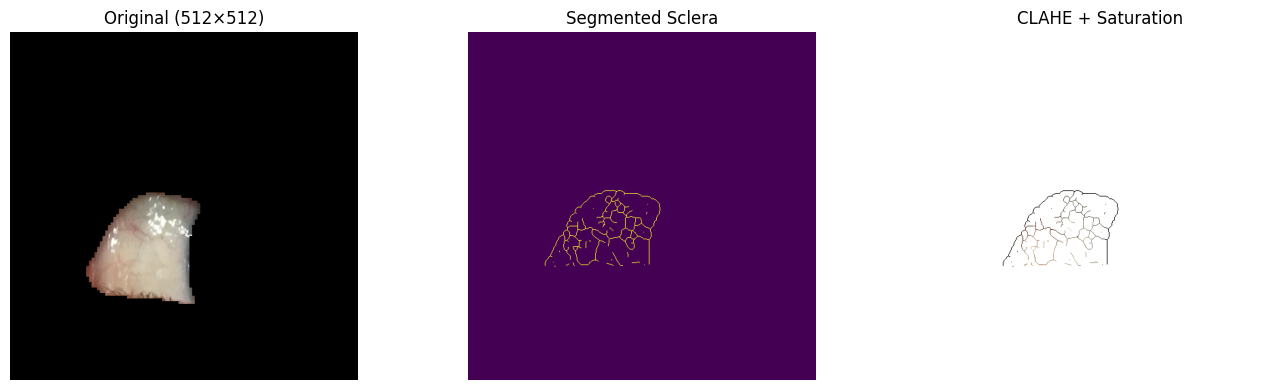

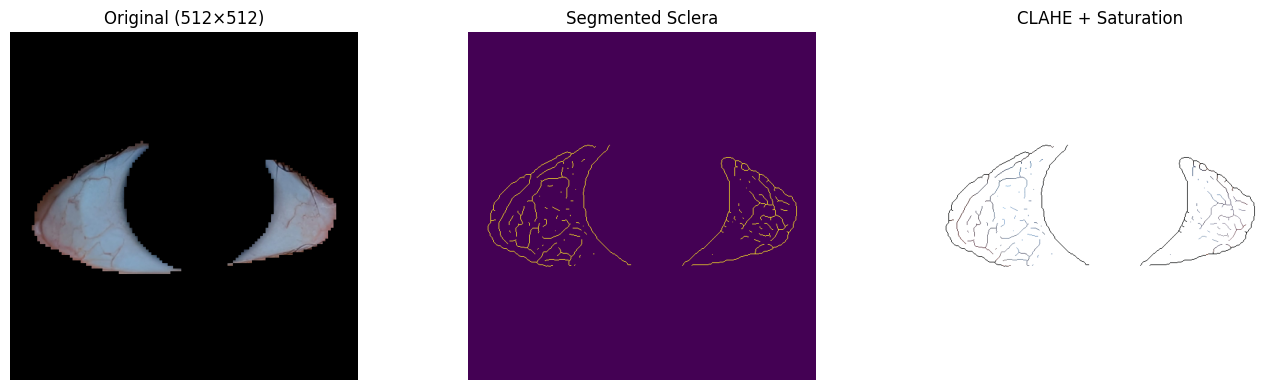

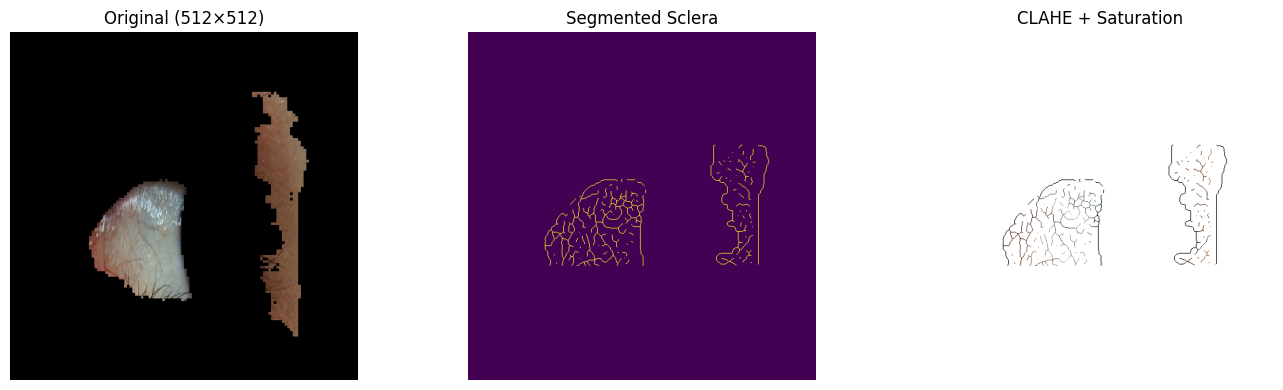

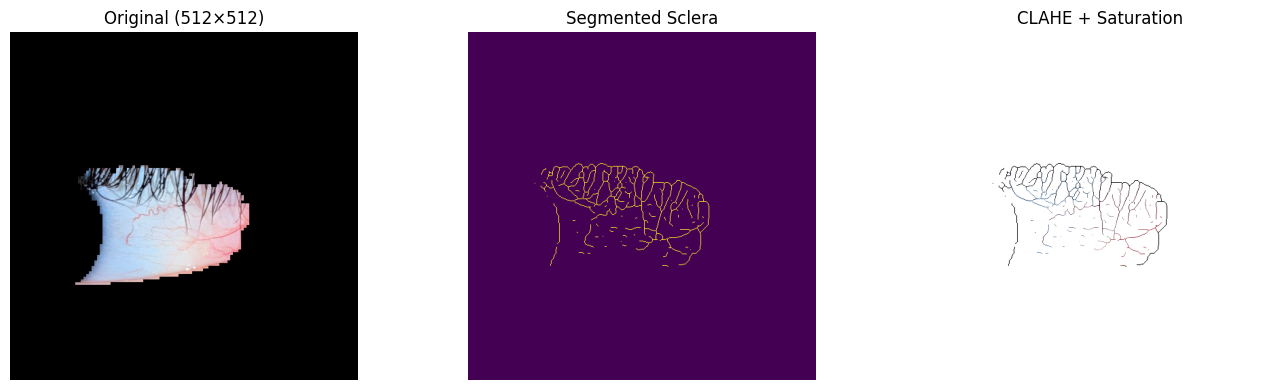

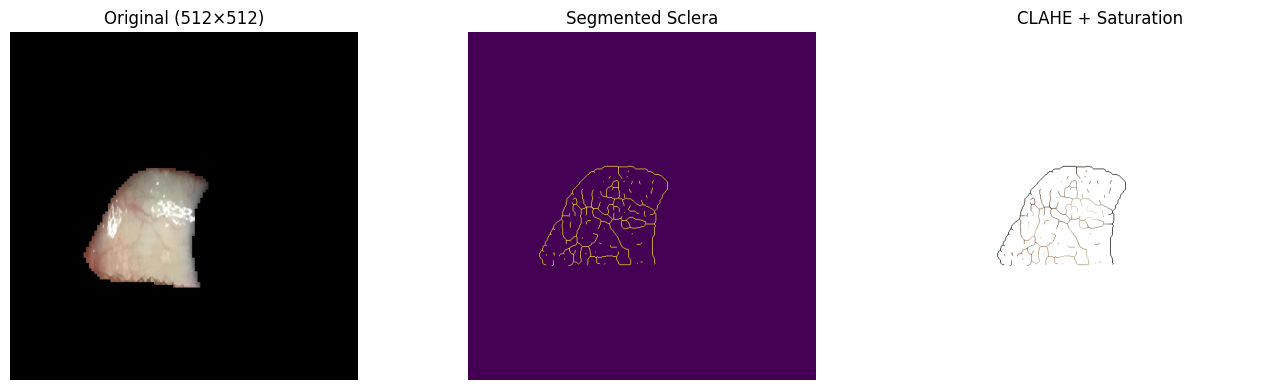

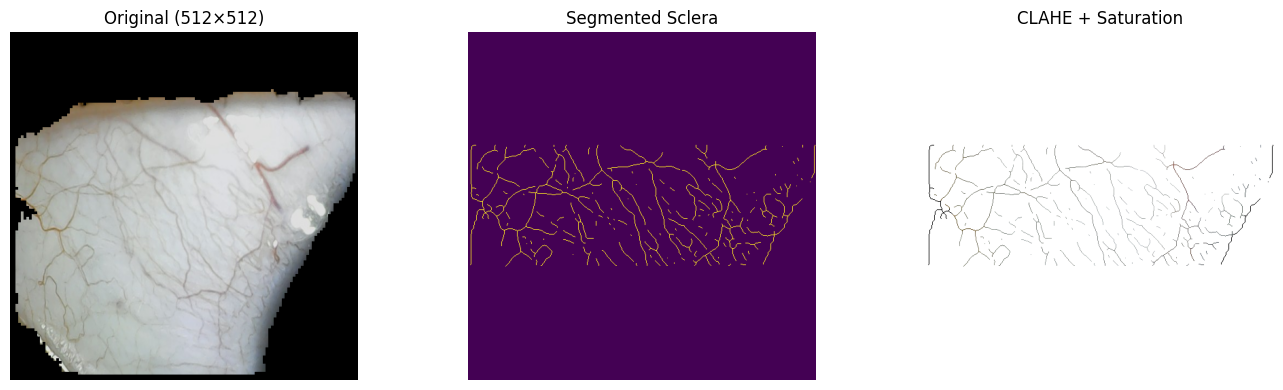

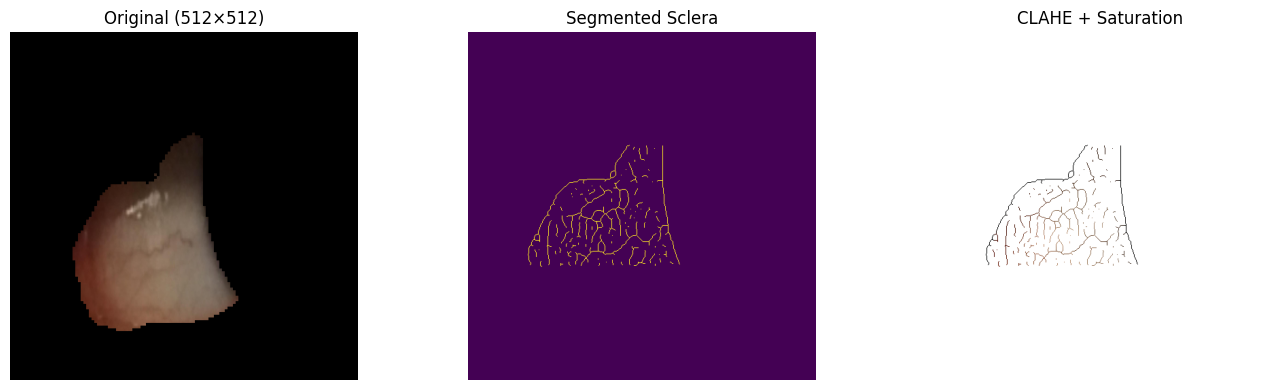

In [15]:
MODEL_PATH = "Model/sclera_iris_segmentation_model.h5"
model = tf.keras.models.load_model(MODEL_PATH, compile=False)
print("✅ Model loaded from", MODEL_PATH)

import cv2
import numpy as np
from skimage.filters import frangi
from skimage.morphology import skeletonize
from skimage import img_as_float


def extract_veins_hsv(img_rgb):
    """
    Uses hue/saturation characteristics to isolate red veins from sclera.
    Returns a binary mask highlighting red/pink vein areas.
    """
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

    h, s, v = cv2.split(hsv)

    # Typical scleral vein color range (reddish)
    lower_red1 = np.array([0, 40, 40])
    upper_red1 = np.array([15, 255, 255])
    lower_red2 = np.array([160, 40, 40])
    upper_red2 = np.array([180, 255, 255])

    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask_red = cv2.bitwise_or(mask1, mask2)

    # Combine with saturation emphasis (high S → veins)
    s_norm = cv2.normalize(s, None, 0, 255, cv2.NORM_MINMAX)
    sat_mask = cv2.threshold(s_norm, 60, 255, cv2.THRESH_BINARY)[1]

    # Intersection = strongly red + highly saturated
    veins = cv2.bitwise_and(mask_red, sat_mask)

    # Clean up small specks
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    veins = cv2.morphologyEx(veins, cv2.MORPH_OPEN, kernel)
    veins = cv2.morphologyEx(veins, cv2.MORPH_CLOSE, kernel)
    return veins

def clean_vein_mask(mask):
    mask = mask.astype(np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel, iterations=1)

    # remove tiny blobs
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(closed)
    filtered = np.zeros_like(mask)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] > 10:   # keep only veins >30 px
            filtered[labels == i] = 255
    return filtered

def sclera_roi(img, height_ratio=0.35):
    """
    Crops the central sclera band, avoiding top/bottom lashes.
    height_ratio defines how tall the middle region is.
    """
    h, w = img.shape[:2]
    band_h = int(h * height_ratio)
    top = (h - band_h) // 2
    bottom = top + band_h
    return img[top:bottom, :]

def extract_focused_veins(img_rgb):
    """
    Extracts only the prominent veins from the clean central sclera region.
    """
    h, w = img_rgb.shape[:2]
    roi = sclera_roi(img_rgb, height_ratio=0.35)

    gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    gray = cv2.bilateralFilter(gray, 7, 75, 75)
    gray_norm = cv2.normalize(gray, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    # Vesselness + gamma boost
    v = frangi(img_as_float(gray_norm), sigmas=range(1,6))
    v = np.nan_to_num(v, nan=0.0)
    v = cv2.normalize(v, None, 0, 1.0, cv2.NORM_MINMAX)
    v = cv2.pow(v, 0.6)
    v = (v * 255).astype(np.uint8)

    # Sensitive threshold
    mean_val, std_val = cv2.meanStdDev(v)
    mean_val, std_val = float(mean_val), float(std_val)
    _, mask = cv2.threshold(v, mean_val + 0.15 * std_val, 255, cv2.THRESH_BINARY)

    # Cleanup + thin veins
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, k, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k, iterations=1)
    skel = skeletonize(mask > 0)
    veins = (skel * 255).astype(np.uint8)

    # Re-embed into full frame
    full = np.zeros((h, w), dtype=np.uint8)
    top = (h - roi.shape[0]) // 2
    full[top:top + roi.shape[0], :] = veins
    return full


def suppress_eyelash_edges(sobel_mag, top_trim=0.12, bottom_trim=0.12):
    """
    Suppresses strong edges from eyelashes or eyelids by masking 
    out the top and bottom bands of the sclera region, while keeping
    the central ellipse intact for vessel detection.
    """
    h, w = sobel_mag.shape

    # Step 1: Elliptical core mask (keeps most of sclera)
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.ellipse(mask, (w//2, h//2), 
                (int(w*0.46), int(h*0.38)), 
                0, 0, 360, 255, -1)

    # Step 2: Explicitly zero-out top/bottom eyelash zones
    top = int(h * top_trim)
    bottom = int(h * (1 - bottom_trim))
    mask[:top, :] = 0
    mask[bottom:, :] = 0

    # Step 3: Apply mask
    masked = cv2.bitwise_and(sobel_mag, sobel_mag, mask=mask)

    # Optional: mild morphological closing to reconnect veins cut at edges
    kernel = np.ones((3,3), np.uint8)
    masked = cv2.morphologyEx(masked, cv2.MORPH_CLOSE, kernel, iterations=1)

    return masked

# -------------------------------
# 2. Prediction helper
# -------------------------------
def predict_sclera_and_vessels(image_path, save_dir="results",
                               seg_size=(128,128), full_size=(512,512),
                               sat_boost=1.4, clip_high=4.0, clip_low=2.0, plot=True):
    """
    Segments the sclera, stretches the mask to full_size (e.g. 512×512),
    applies CLAHE for local contrast and boosts saturation.

    No edge detection or vessel filtering — lets the model learn features directly.
    """
    os.makedirs(save_dir, exist_ok=True)

    # --- Load image ---
    img_bgr = image_path
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_full = cv2.resize(img_rgb, full_size)

    # --- Segment sclera (low-res) ---
    img_small = cv2.resize(img_rgb, seg_size)
    inp = np.expand_dims(img_small / 255.0, axis=0)
    pred = model.predict(inp, verbose=0)
    pred_mask = np.argmax(pred[0], axis=-1)

    # --- Stretch mask to full resolution ---
    mask_resized = cv2.resize(pred_mask.astype(np.uint8), full_size,
                              interpolation=cv2.INTER_NEAREST)

    # --- Extract sclera region ---
    sclera_mask = (mask_resized == 1).astype(np.uint8) * 255
    sclera_only = cv2.bitwise_and(img_full, img_full, mask=sclera_mask)

    # --- CLAHE for local contrast ---
    gray = cv2.cvtColor(sclera_only, cv2.COLOR_RGB2GRAY)
    mean_intensity = np.mean(gray)
    clip = clip_low if mean_intensity > 110 else clip_high
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(8,8))
    L = clahe.apply(gray)

    # --- Replace L channel in LAB with enhanced one for natural contrast boost ---
    lab = cv2.cvtColor(sclera_only, cv2.COLOR_RGB2LAB)
    L_orig, A, B = cv2.split(lab)
    lab_enh = cv2.merge([L, A, B])
    sclera_clahe = cv2.cvtColor(lab_enh, cv2.COLOR_LAB2RGB)

    # --- Saturation boost (emphasize subtle red veins) ---
    hsv = cv2.cvtColor(sclera_clahe, cv2.COLOR_RGB2HSV)
    hsv[...,1] = cv2.multiply(hsv[...,1], sat_boost)
    hsv[...,1] = np.clip(hsv[...,1], 0, 255)
    sclera_sat = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    veinmap = extract_focused_veins(sclera_sat)
    #sclera_sat = cv2.cvtColor(sclera_sat, cv2.COLOR_RGB2GRAY)
    combined = np.concatenate([sclera_sat / 255.0, veinmap[..., None] / 255.0], axis=-1)
    #veinmap = clean_vein_mask(veinmap)


    # ---------------------------------------------------
    # Visualization
    # ---------------------------------------------------
    if plot:
        plt.figure(figsize=(14,4))
        plt.subplot(1,3,1); plt.imshow(sclera_only); plt.title("Original (512×512)"); plt.axis('off')
        plt.subplot(1,3,2); plt.imshow(veinmap); plt.title("Segmented Sclera"); plt.axis('off')
        plt.subplot(1,3,3); plt.imshow(combined); plt.title("CLAHE + Saturation"); plt.axis('off')
        plt.tight_layout()
        plt.show()
    

    # Return the simple saturated sclera image
    return veinmap



# ---------------------------------------------------
# 3. Run on test images
# ---------------------------------------------------
TEST_DIR = "Tests/"   # folder containing new eye images
if os.path.isdir(TEST_DIR):
    # Process all images in the directory
    for f in os.listdir(TEST_DIR):
        if f.lower().endswith((".jpg", ".png", ".jpeg")):
            image_path = os.path.join(TEST_DIR, f)
            image_path = cv2.imread(image_path)
            if image_path is None:
                print(f"File does not exist: {image_path}")
                continue
            predict_sclera_and_vessels(image_path, save_dir="results")
else:
    # Process a single image file
    predict_sclera_and_vessels(TEST_DIR, save_dir="results")



/tmp/ipykernel_14542/3972342552.py:89: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean_val, std_val = float(mean_val), float(std_val)


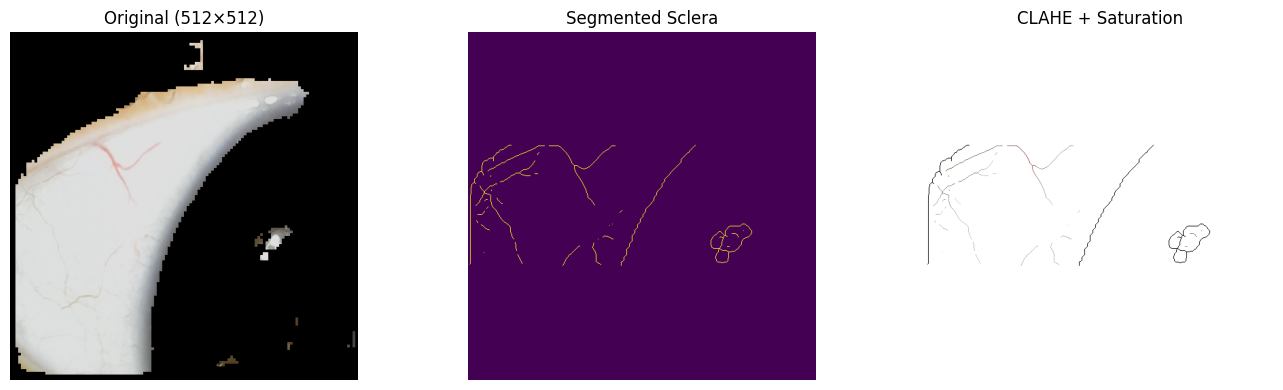

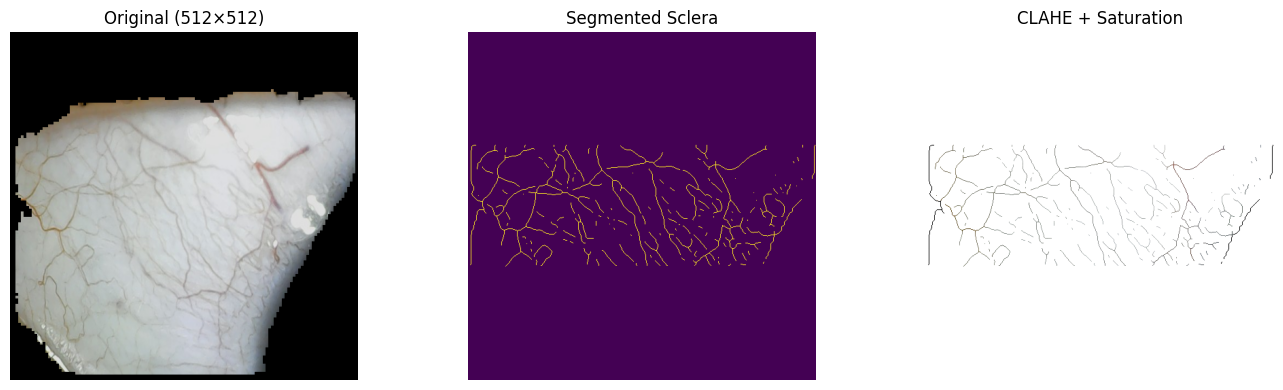

✅ SSIM similarity score: 0.8283


In [16]:
from skimage.metrics import structural_similarity as ssim
def ssim_similarity(img1, img2):
    """Return SSIM float between two RGB or multi-channel images."""
    if img1.ndim == 3:
        g1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
        g2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    else:
        g1, g2 = img1, img2

    # Determine range automatically
    data_range = 1.0 if np.issubdtype(g1.dtype, np.floating) else 255.0
    score, _ = ssim(g1, g2, full=True, data_range=data_range)
    return float(score)


# --- Safe image loader ---
def safe_imread(path):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"❌ Could not read image: {path}")
    return img

# --- Paths ---
path1 = "Tests/test2.jpeg"
path2 = "Tests/test3.jpeg"

# --- Load safely ---
img1 = safe_imread(path1)
img2 = safe_imread(path2)

# --- Resize to 512×512 ---
img1 = cv2.resize(img1, (512, 512))
img2 = cv2.resize(img2, (512, 512))

# --- Run your vessel prediction ---
img1_veins = predict_sclera_and_vessels(img1, plot=True)
img2_veins = predict_sclera_and_vessels(img2, plot=True)

# --- Compute SSIM ---
ssim_score = ssim_similarity(img1_veins, img2_veins)
print(f"✅ SSIM similarity score: {ssim_score:.4f}")

In [17]:
import cv2
import numpy as np

def sift_similarity(images, ratio_thresh=0.75, visualize=False):
    """
    Computes SIFT-based similarity between 2 or more RGB images.

    Parameters
    ----------
    images : list[np.ndarray]
        List of RGB images (each H×W×3, dtype uint8 or float32 [0–1]).
    ratio_thresh : float
        Lowe’s ratio test threshold for match filtering (default=0.75).
    visualize : bool
        If True and exactly two images are given, returns a match visualization image.

    Returns
    -------
    result : dict
        {
          'pair_scores': [(i, j, score, mean_distance, num_matches, num_kp_i, num_kp_j), ...],
          'mean_score': float,
          'visual': (optional) match image if visualize=True and len(images)==2
        }
    """

    if len(images) < 2:
        raise ValueError("Need at least 2 images for SIFT comparison.")

    # Initialize SIFT detector
    sift = cv2.SIFT_create()
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

    pair_results = []
    vis_img = None

    for i in range(len(images)):
        for j in range(i + 1, len(images)):
            img1 = images[i]
            img2 = images[j]

            # Convert to grayscale
            if img1.ndim == 3:
                img1_gray = cv2.cvtColor((img1 * 255).astype(np.uint8) if img1.max() <= 1 else img1, cv2.COLOR_RGB2GRAY)
            else:
                img1_gray = img1
            if img2.ndim == 3:
                img2_gray = cv2.cvtColor((img2 * 255).astype(np.uint8) if img2.max() <= 1 else img2, cv2.COLOR_RGB2GRAY)
            else:
                img2_gray = img2

            # Detect keypoints and descriptors
            kp1, des1 = sift.detectAndCompute(img1_gray, None)
            kp2, des2 = sift.detectAndCompute(img2_gray, None)

            if des1 is None or des2 is None:
                pair_results.append((i, j, 0, 0, 0, len(kp1 or []), len(kp2 or [])))
                continue

            # KNN matching
            matches = bf.knnMatch(des1, des2, k=2)
            good_matches = [m for m, n in matches if m.distance < ratio_thresh * n.distance]

            num_good = len(good_matches)
            score = num_good / max(len(kp1), len(kp2), 1)  # normalized score [0–1]
            mean_dist = np.mean([m.distance for m in good_matches]) if num_good > 0 else np.inf

            pair_results.append((i, j, score, mean_dist, num_good, len(kp1), len(kp2)))

            # Optional visualization
            if visualize and len(images) == 2:
                vis_img = cv2.drawMatches(
                    img1, kp1, img2, kp2, good_matches, None,
                    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
                )

    mean_score = np.mean([s[2] for s in pair_results]) if pair_results else 0.0

    result = {
        "pair_scores": pair_results,
        "mean_score": mean_score
    }
    if vis_img is not None:
        result["visual"] = vis_img

    return result


In [18]:
import os, re, random, cv2, numpy as np
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim

IMG_SIZE_SEG = (128,128)
FULL_SIZE    = (256,256)

VALID_GAZE_COMBOS = [
    ('s','s'), ('l','l'), ('r','r'), ('u','u')
]

# ---------------------- Utilities ----------------------

# def ssim_similarity(img1, img2):
#     """Return SSIM float between two RGB images."""
#     g1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
#     g2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
#     score, _ = ssim(g1, g2, full=True)
#     return float(score)

def enhance_veins(img_rgb, contrast_boost=1.5):
    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    L, A, B = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    L = clahe.apply(L)
    lab_enh = cv2.merge([L, A, B])
    img = cv2.cvtColor(lab_enh, cv2.COLOR_LAB2RGB)

    img_float = img.astype(np.float32) / 255.0
    mean = np.mean(img_float)
    img_boost = np.clip((img_float - mean) * contrast_boost + mean, 0, 1)
    img_boost = np.power(img_boost, 1.0 / contrast_boost)
    img_boost = (img_boost * 255).astype(np.uint8)

    r, g, b = cv2.split(img_boost)
    vein_map = cv2.subtract(g, r)
    vein_map = cv2.normalize(vein_map, None, 0, 255, cv2.NORM_MINMAX)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    veins = cv2.morphologyEx(vein_map, cv2.MORPH_TOPHAT, kernel)
    img_boost[..., 1] = cv2.addWeighted(img_boost[..., 1], 0.7, veins, 0.3, 0)
    return img_boost

# ---------------------- Main Builder ----------------------

def make_siamese_dataset_from_schema(
        img_root, seg_model,
        max_pos=300, max_neg=300,
        seed=42,
        sat_boost=1.4):

    rng = random.Random(seed)

    # --- Regex parser ---
    name_re = re.compile(
        r'^(\d+_\d+)([a-zA-Z])_([LR])([slruSLRU])_([12])\.(jpg|png)$',
        re.IGNORECASE
    )

    def parse_name(fname):
        m = name_re.match(fname)
        if not m:
            return None
        pid   = m.group(1)
        flag  = m.group(2).lower()
        eye   = m.group(3).upper()
        gaze  = m.group(4).lower()
        idx   = int(m.group(5))
        return pid, flag, eye, gaze, idx

    def is_bad(fname):
        return fname.lower().endswith('_bad.jpg') or fname.lower().endswith('_bad.png')

    def fix_image_shape(img, size=(256,256)):
        """Guarantee 3-channel float32 normalized image of given size."""
        if img is None:
            return None
        if img.ndim == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[-1] == 1:
            img = np.repeat(img, 3, axis=-1)
        img = cv2.resize(img, size)
        return img.astype(np.float32) / 255.0

    # --- Index images ---
    data, all_by_eye_gaze = {}, {}
    total_files = 0
    for sub in sorted(os.listdir(img_root)):
        subdir = os.path.join(img_root, sub)
        if not os.path.isdir(subdir):
            continue
        for f in os.listdir(subdir):
            fl = f.lower()
            if not (fl.endswith('.jpg') or fl.endswith('.png')) or is_bad(f):
                continue
            parsed = parse_name(f)
            if not parsed:
                continue
            pid, flag, eye, gaze, idx = parsed
            if flag == 'p':  # skip blurry
                continue
            full_path = os.path.join(subdir, f)
            data.setdefault(pid, {}).setdefault(eye, {}).setdefault(gaze, {})[idx] = full_path
            all_by_eye_gaze.setdefault((eye, gaze), []).append((pid, full_path))
            total_files += 1

    print(f"Indexed files: {total_files}")
    print(f"Unique people: {len(data)}")

    # --- YES pairs ---
    X1, X2, y = [], [], []
    pos_cnt = 0
    print("✅ Building YES pairs (same person / same eye)…")

    with tqdm(total=max_pos, desc="YES pairs", dynamic_ncols=True) as pbar:
        for pid, eyes in data.items():
            for eye, gazes in eyes.items():
                # same gaze 1↔2
                for gaze, idx_map in gazes.items():
                    if pos_cnt >= max_pos: break
                    if 1 in idx_map and 2 in idx_map:
                        f1, f2 = idx_map[1], idx_map[2]
                        try:
                            ia = cv2.cvtColor(cv2.imread(f1), cv2.COLOR_BGR2RGB)
                            ib = cv2.cvtColor(cv2.imread(f2), cv2.COLOR_BGR2RGB)
                            ia = predict_sclera_and_vessels(ia, plot=False)
                            ib = predict_sclera_and_vessels(ib, plot=False)
                            ia = fix_image_shape(ia)
                            ib = fix_image_shape(ib)
                            if ia is None or ib is None: continue
                            X1.append(ia); X2.append(ib); y.append(0)
                            pos_cnt += 1; pbar.update(1)
                        except Exception as e:
                            print("Same-gaze error:", e)
                if pos_cnt >= max_pos: break

                # cross gaze
                available_gazes = list(gazes.keys())
                for g1, g2 in VALID_GAZE_COMBOS:
                    if pos_cnt >= max_pos: break
                    if g1 == g2 or g1 not in available_gazes or g2 not in available_gazes:
                        continue
                    f1 = gazes[g1].get(1) or gazes[g1].get(2)
                    f2 = gazes[g2].get(1) or gazes[g2].get(2)
                    if not (f1 and f2): continue
                    try:
                        ia = cv2.cvtColor(cv2.imread(f1), cv2.COLOR_BGR2RGB)
                        ib = cv2.cvtColor(cv2.imread(f2), cv2.COLOR_BGR2RGB)
                        ia = predict_sclera_and_vessels(ia, plot=False)
                        ib = predict_sclera_and_vessels(ib, plot=False)
                        ia = fix_image_shape(ia)
                        ib = fix_image_shape(ib)
                        if ia is None or ib is None: continue
                        X1.append(ia); X2.append(ib); y.append(0)
                        pos_cnt += 1; pbar.update(1)
                    except Exception as e:
                        print("Cross-gaze error:", e)
            if pos_cnt >= max_pos: break

    # --- NO pairs ---
    neg_cnt = 0
    print("🚫 Building NO pairs (different person / same gaze)…")
    with tqdm(total=max_neg, desc="NO pairs", dynamic_ncols=True) as pbar:
        for (eye, gaze), items in all_by_eye_gaze.items():
            if neg_cnt >= max_neg: break
            if len(items) < 2: continue
            rng.shuffle(items)
            for i in range(len(items) - 1):
                if neg_cnt >= max_neg: break
                pid1, f1 = items[i]
                for j in range(i + 1, len(items)):
                    pid2, f2 = items[j]
                    if pid1 == pid2: continue
                    try:
                        ia = cv2.cvtColor(cv2.imread(f1), cv2.COLOR_BGR2RGB)
                        ib = cv2.cvtColor(cv2.imread(f2), cv2.COLOR_BGR2RGB)
                        ia = predict_sclera_and_vessels(ia, plot=False)
                        ib = predict_sclera_and_vessels(ib, plot=False)
                        ia = fix_image_shape(ia)
                        ib = fix_image_shape(ib)
                        if ia is None or ib is None: continue
                        X1.append(ia); X2.append(ib); y.append(1)
                        neg_cnt += 1; pbar.update(1)
                        break
                    except Exception as e:
                        print("NO pair error:", e)
                        continue
            if neg_cnt >= max_neg: break

    X1 = np.array(X1, np.float32)
    X2 = np.array(X2, np.float32)
    y  = np.array(y,  np.uint8)
    print(f"\n✅ Dataset Ready → YES={pos_cnt}, NO={neg_cnt}")
    print(f"Shapes → X1={X1.shape}, X2={X2.shape}, y={y.shape}")
    return X1, X2, y

In [19]:
X1, X2, y = make_siamese_dataset_from_schema("MOBIUS/Images", max_pos=1000, max_neg=1000, seg_model=model)
## we need to shuffle the dataset here
min_len = min(len(X1), len(X2), len(y))
X1, X2, y = X1[:min_len], X2[:min_len], y[:min_len]

# Create a single permutation and apply jointly
idx = np.arange(min_len)
np.random.shuffle(idx)

X1 = X1[idx]
X2 = X2[idx]
y = y[idx]



Indexed files: 9530
Unique people: 300
✅ Building YES pairs (same person / same eye)…


YES pairs:   0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_14542/3972342552.py:89: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean_val, std_val = float(mean_val), float(std_val)
YES pairs: 100%|██████████| 1000/1000 [07:32<00:00,  2.21it/s]


🚫 Building NO pairs (different person / same gaze)…


NO pairs: 100%|██████████| 1000/1000 [07:44<00:00,  2.15it/s]



✅ Dataset Ready → YES=1000, NO=1000
Shapes → X1=(2000, 256, 256, 3), X2=(2000, 256, 256, 3), y=(2000,)


In [20]:
### we load the npz files and combine them into one final dataset
# data_pos = np.load("siamese_data_part_pos_YES.npz")
# data_neg = np.load("siamese_data_part_pos_NO.npz")
# X1_pos, X2_pos, y_pos = data_pos['X1'], data_pos['X2'], data_pos['y']
# X1_neg, X2_neg, y_neg = data_neg['X1'], data_neg['X2'], data_neg['y']

# X1 = np.concatenate([X1_pos, X1_neg], axis=0)
# X2 = np.concatenate([X2_pos, X2_neg], axis=0)
# y  = np.concatenate([y_pos, y_neg], axis=0)

# # Shuffle the combined dataset
# min_len = min(len(X1), len(X2), len(y))
# X1, X2, y = X1[:min_len], X2[:min_len], y[:min_len]
# idx = np.arange(min_len)
# np.random.shuffle(idx)

# X1 = X1[idx]
# X2 = X2[idx]
# y = y[idx]

# ### print out the shapes
# print(f"Final dataset shapes → X1={X1.shape}, X2={X2.shape}, y={y.shape}")

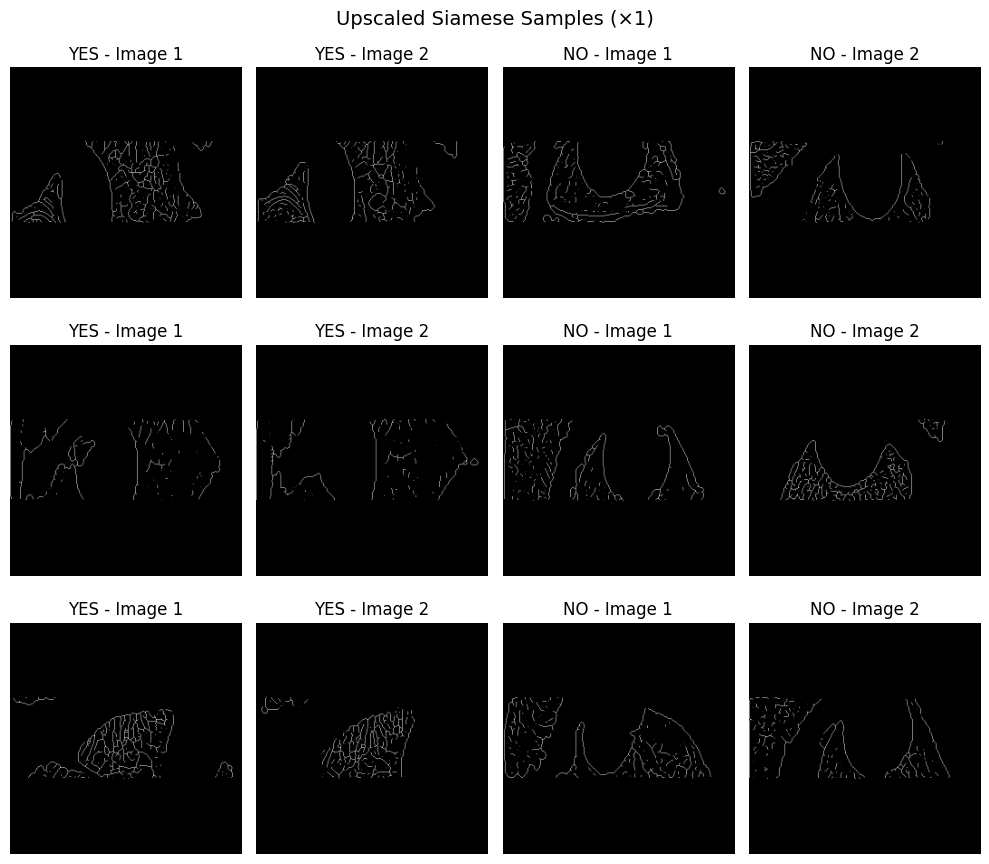

Final dataset shapes: (2000, 256, 256, 3) (2000, 256, 256, 3) (2000,)
Trimmed dataset to 2000 samples (consistent across X1, X2, y)


In [21]:
import matplotlib.pyplot as plt
import random



def show_siamese_samples(X1, X2, y, num_samples=3, upscale=2):
    """
    Displays example pairs from the Siamese dataset.
    Optionally upsamples images for clearer visualization (does NOT alter data).
    """
    yes_indices = [i for i, label in enumerate(y) if label == 0]
    no_indices = [i for i, label in enumerate(y) if label == 1]

    if not yes_indices or not no_indices:
        print("⚠️ Not enough YES/NO samples to display!")
        return

    plt.figure(figsize=(10, num_samples * 3))

    for n in range(num_samples):
        yes_idx = random.choice(yes_indices)
        no_idx = random.choice(no_indices)

        # Helper: upscale with bicubic interpolation
        def upscale_img(img):
            h, w = img.shape[:2]
            return cv2.resize(img, (w * upscale, h * upscale), interpolation=cv2.INTER_CUBIC)

        # YES pair
        plt.subplot(num_samples, 4, 4 * n + 1)
        plt.imshow(upscale_img(X1[yes_idx].squeeze()), cmap='gray')
        plt.title("YES - Image 1")
        plt.axis('off')

        plt.subplot(num_samples, 4, 4 * n + 2)
        plt.imshow(upscale_img(X2[yes_idx].squeeze()), cmap='gray')
        plt.title("YES - Image 2")
        plt.axis('off')

        # NO pair
        plt.subplot(num_samples, 4, 4 * n + 3)
        plt.imshow(upscale_img(X1[no_idx].squeeze()), cmap='gray')
        plt.title("NO - Image 1")
        plt.axis('off')

        plt.subplot(num_samples, 4, 4 * n + 4)
        plt.imshow(upscale_img(X2[no_idx].squeeze()), cmap='gray')
        plt.title("NO - Image 2")
        plt.axis('off')

    plt.suptitle(f"Upscaled Siamese Samples (×{upscale})", fontsize=14)
    plt.tight_layout()
    plt.show()

show_siamese_samples(X1, X2, y, num_samples=3, upscale=1)

min_len = min(len(X1), len(X2), len(y))
X1 = X1[:min_len]
X2 = X2[:min_len]
y  = y[:min_len]

print("Final dataset shapes:", X1.shape, X2.shape, y.shape)

print(f"Trimmed dataset to {min_len} samples (consistent across X1, X2, y)")

In [22]:
print(y[0:10])
### processed output saved in .npy file
# np.savez_compressed("siamese_sclera_dataset.npz", X1=X1, X2=X2, y=y)

[0 1 1 1 0 1 1 0 0 1]


In [23]:
# import numpy as np
# ### save the dataset for future use
# data = [X1, X2, y]
# np.save("Preprocessed/siamese_X1.npy", data)

### Siamese model 1

In [24]:
# import tensorflow as tf
# from tensorflow.keras import layers, Model, Input

# def build_siamese_encoder(input_shape=(224,224,3)):
#     inp = Input(shape=input_shape)

#     # --- Block 1 ---
#     x = layers.Conv2D(32, 3, padding='same', activation='relu')(inp)
#     x = layers.BatchNormalization()(x)
#     x = layers.MaxPooling2D()(x)

#     # --- Block 2 ---
#     x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.MaxPooling2D()(x)

#     # --- Block 3 ---
#     x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.GlobalAveragePooling2D()(x)

#     # --- Dense projection ---
#     x = layers.Dense(256, activation='relu')(x)
#     x = layers.Dropout(0.4)(x)
#     out = layers.Dense(128, activation='relu')(x)
#     return Model(inp, out, name="SiameseEncoder")


# def build_siamese_network(input_shape=(256,256,3)):
#     base_encoder = build_siamese_encoder(input_shape)

#     input_a = Input(shape=input_shape)
#     input_b = Input(shape=input_shape)

#     feat_a = base_encoder(input_a)
#     feat_b = base_encoder(input_b)

#     # Distance metric (L1 distance)
#     diff = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([feat_a, feat_b])

#     x = layers.Dense(64, activation='relu')(diff)
#     x = layers.Dropout(0.3)(x)
#     out = layers.Dense(1, activation='sigmoid')(x)

#     return Model([input_a, input_b], out, name="SiameseNetwork")



import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import regularizers



# ------------------------------------------------------------
# 2. Cosine learning-rate scheduler (fixed)
# ------------------------------------------------------------
def rampup_cosine_schedule(initial_lr=1e-5, max_lr=3e-4, warmup_epochs=5, total_epochs=80):
    def scheduler(epoch, lr=None):
        if epoch < warmup_epochs:
            # Linear warmup
            return float(initial_lr + (max_lr - initial_lr) * (epoch / warmup_epochs))
        # Cosine decay after warmup
        progress = (epoch - warmup_epochs) / float(total_epochs - warmup_epochs)
        decay = 0.5 * (1 + tf.math.cos(3.14159 * progress))
        return float(max_lr * decay)
    return tf.keras.callbacks.LearningRateScheduler(scheduler)

# ------------------------------------------------------------
# 3. Build Siamese Model (Multi-Scale + Regularization)
# ------------------------------------------------------------
def build_sclera_siamese(input_shape=(256,256,3)):
    def encoder_block():
        inp = Input(shape=input_shape)
        x = layers.Conv2D(32, 3, padding='same', activation='relu')(inp)
        x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
        x = layers.MaxPooling2D(2)(x)

        x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
        x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
        x = layers.MaxPooling2D(2)(x)

        x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
        x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dropout(0.3)(x)
        out = layers.Dense(128, activation=None)(x)
        out = layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(out)
        return Model(inp, out, name="ScleraEncoder")

    encoder = encoder_block()
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    feat_a = encoder(input_a)
    feat_b = encoder(input_b)

    # Euclidean distance
    dist = layers.Lambda(lambda x: tf.sqrt(tf.reduce_sum(tf.square(x[0] - x[1]), axis=1, keepdims=True)+1e-6))([feat_a, feat_b])
    return Model([input_a, input_b], dist, name="ScleraSiamese")




In [36]:
input_shape = (256, 256, 3)

import tensorflow as tf

class StructuralSSIMContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, margin=0.6, alpha=0.3, name="structural_ssim_contrastive"):
        """
        margin: contrastive separation margin
        alpha: weight for structural SSIM regularization
        """
        super().__init__(name=name)
        self.margin = margin
        self.alpha = alpha

    def call(self, y_true, y_pred, img1=None, img2=None):
        """
        y_true: [batch, 1]  (0 = same, 1 = different)
        y_pred: predicted distance (Euclidean or cosine)
        img1, img2: optional — to compute s-SSIM on inputs or features
        """
        y_true = tf.cast(y_true, tf.float32)

        # --- Contrastive loss ---
        pos_loss = (1 - y_true) * tf.square(y_pred)
        neg_loss = y_true * tf.square(tf.maximum(self.margin - y_pred, 0))
        contrastive_loss = tf.reduce_mean(pos_loss + neg_loss)

        # --- Structural SSIM (if provided) ---
        if img1 is not None and img2 is not None:
            ssim_map = tf.image.ssim_multiscale(img1, img2, max_val=1.0)
            # structural term: invariant to contrast/brightness
            struct_loss = tf.reduce_mean((1 - y_true) * (1 - ssim_map))
            total = contrastive_loss + self.alpha * struct_loss
        else:
            total = contrastive_loss

        return total


loss_fn = StructuralSSIMContrastiveLoss(margin=1.2, alpha=0.1)

def contrastive_loss(y_true, y_pred, margin=0.4):
    y_true = tf.cast(y_true, tf.float32)
    return tf.reduce_mean(y_true * tf.square(y_pred) + (1 - y_true) * tf.square(tf.maximum(margin - y_pred, 0)))

siamese_model = build_sclera_siamese()
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=contrastive_loss)
siamese_model.summary()

Model: "ScleraSiamese"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ScleraEncoder       │ (None, 128)       │    352,928 │ input_layer_12[0… │
│ (Functional)        │                   │            │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, 1)         │          0 │ ScleraEncoder[0]… │
│                     │                   │            │ ScleraEncoder[1]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 352,928 (1.35 MB)

 Trainable params: 352,928 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
lr_callback = rampup_cosine_schedule(
    initial_lr=1e-5, 
    max_lr=3e-4, 
    warmup_epochs=5, 
    total_epochs=20
)
history = siamese_model.fit(
    [X1, X2], y,
    validation_split=0.2,
    epochs=20,
    batch_size=8,
    callbacks=[lr_callback],
    verbose=1
)



2025-11-26 17:52:27.735148: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1258291200 exceeds 10% of free system memory.
2025-11-26 17:52:29.033564: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1258291200 exceeds 10% of free system memory.


Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - loss: 0.1642 - val_loss: 0.0674 - learning_rate: 1.0000e-05
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0412 - val_loss: 0.0690 - learning_rate: 6.8000e-05
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0406 - val_loss: 0.0704 - learning_rate: 1.2600e-04
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0401 - val_loss: 0.0723 - learning_rate: 1.8400e-04
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 0.0395 - val_loss: 0.0695 - learning_rate: 2.4200e-04
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.0367 - val_loss: 0.0739 - learning_rate: 3.0000e-04
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 0.0369 - val_loss: 0.0700 - learning_rate: 2.9672e-04
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 0.0340 - val_loss: 0.0701 - learning_rate: 2.8703e-04
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.0331 - v

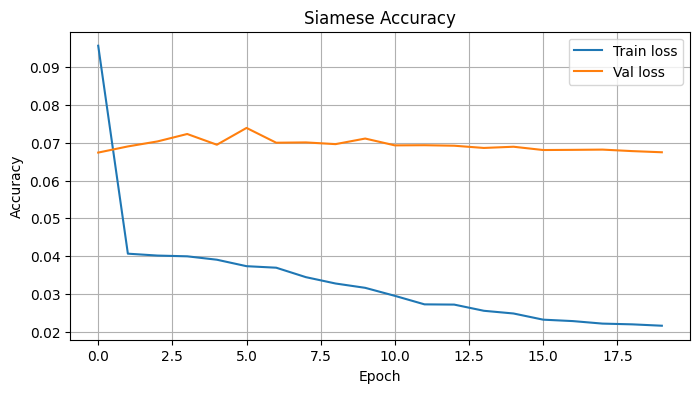

In [39]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(8,4))
# plt.plot(history.history['lambda'], label='Train Acc')
# plt.plot(history.history['val_lambda'], label='Val Acc')
# plt.title('Siamese Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)
# # plt.show()


plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title('Siamese Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_14542/3972342552.py:89: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean_val, std_val = float(mean_val), float(std_val)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Predicted distance: [[0.10053198]]
SSIM similarity score: 0.44416942537309484
Predicted Distance: 0.1005
Similarity Score: 0.8995  →  Classified as SAME


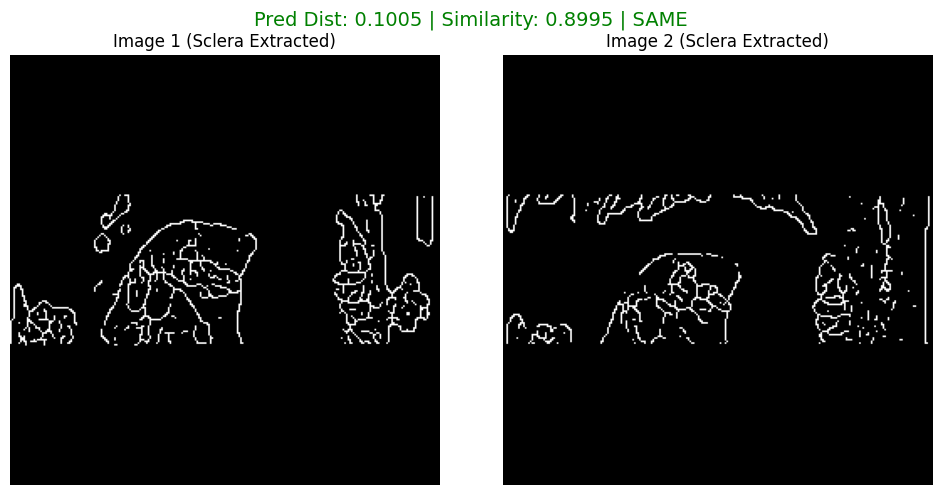

In [45]:
def predict_sclera_and_vessels(image_path, save_dir="results",
                               seg_size=(128,128), full_size=(512,512),
                               sat_boost=1.4, clip_high=4.0, clip_low=2.0, plot=True):
    """
    Returns a 256×256×3 sclera-enhanced image compatible with the Siamese network.
    """
    os.makedirs(save_dir, exist_ok=True)

    # --- Load image ---
    img_bgr = image_path
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_full = cv2.resize(img_rgb, full_size)

    # --- Segment sclera (low-res) ---
    img_small = cv2.resize(img_rgb, seg_size)
    inp = np.expand_dims(img_small / 255.0, axis=0)
    pred = model.predict(inp, verbose=0)
    pred_mask = np.argmax(pred[0], axis=-1)

    # --- Stretch mask to full resolution ---
    mask_resized = cv2.resize(pred_mask.astype(np.uint8), full_size,
                              interpolation=cv2.INTER_NEAREST)

    # --- Extract sclera ---
    sclera_mask = (mask_resized == 1).astype(np.uint8) * 255
    sclera_only = cv2.bitwise_and(img_full, img_full, mask=sclera_mask)

    # --- CLAHE locally ---
    gray = cv2.cvtColor(sclera_only, cv2.COLOR_RGB2GRAY)
    mean_intensity = np.mean(gray)
    clip = clip_low if mean_intensity > 110 else clip_high
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(8,8))
    L = clahe.apply(gray)

    lab = cv2.cvtColor(sclera_only, cv2.COLOR_RGB2LAB)
    L_orig, A, B = cv2.split(lab)
    lab_enh = cv2.merge([L, A, B])
    sclera_clahe = cv2.cvtColor(lab_enh, cv2.COLOR_LAB2RGB)

    # --- Saturation boost ---
    hsv = cv2.cvtColor(sclera_clahe, cv2.COLOR_RGB2HSV)
    hsv[...,1] = cv2.multiply(hsv[...,1], sat_boost)
    hsv[...,1] = np.clip(hsv[...,1], 0, 255)
    sclera_sat = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    # --- Extract veins (your function) ---
    veinmap = extract_focused_veins(sclera_sat)   # ← 1-channel

    # ---------------------------------------------------------
    # 🔥 FIX 1 — Resize everything to 256×256
    # ---------------------------------------------------------
    sclera_sat_256 = cv2.resize(sclera_sat, (256,256))
    veinmap_256 = cv2.resize(veinmap, (256,256))

    # ---------------------------------------------------------
    # 🔥 FIX 2 — Convert veinmap (1-channel) → RGB
    # ---------------------------------------------------------
    veinmap_rgb = cv2.cvtColor(veinmap_256, cv2.COLOR_GRAY2RGB)

    # ---------------------------------------------------------
    # 🔥 Siamese expects (256,256,3)
    # ---------------------------------------------------------
    final_out = veinmap_rgb.astype(np.float32)

    # ---------------------------------------------------------
    # Visualization
    # ---------------------------------------------------------
    if plot:
        plt.figure(figsize=(14,4))
        plt.subplot(1,3,1); plt.imshow(sclera_only); plt.title("Sclera Only"); plt.axis('off')
        plt.subplot(1,3,2); plt.imshow(veinmap_256); plt.title("Vein Map (256×256)"); plt.axis('off')
        plt.subplot(1,3,3); plt.imshow(final_out.astype(np.uint8)); plt.title("Final Output (RGB)"); plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    return final_out


img1 = cv2.cvtColor(cv2.imread("Tests/93_2i_Ll_1.jpg"), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread("Tests/93_2i_Ll_2.jpg"), cv2.COLOR_BGR2RGB)
img1_r = cv2.resize(img1, (256, 256))
img2_r = cv2.resize(img2, (256, 256))
X1_test = predict_sclera_and_vessels(img1, plot=False)
X2_test = predict_sclera_and_vessels(img2, plot=False)
#siamese_model = tf.keras.models.load_model("Model/siamese_inception_sclera_vessel_model.h5", compile=False)
# Add batch dimension
X1_test = np.expand_dims(X1_test, axis=0)
X2_test = np.expand_dims(X2_test, axis=0)

# Predict distance
dist = siamese_model.predict([X1_test, X2_test])
print("Predicted distance:", dist)
print("SSIM similarity score:", ssim_similarity(img1_r, img2_r))

dist = float(dist.item())   # ✅ convert array → Python float
similarity = 1.0 - dist     # invert distance

# Classification threshold (tune empirically)
threshold = 0.79
label = "SAME" if similarity >= threshold else "DIFFERENT"

print(f"Predicted Distance: {dist:.4f}")
print(f"Similarity Score: {similarity:.4f}  →  Classified as {label}")

# ---------- Plot results ----------
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(X1_test[0])
axes[0].set_title("Image 1 (Sclera Extracted)")
axes[0].axis('off')
axes[1].imshow(X2_test[0])
axes[1].set_title("Image 2 (Sclera Extracted)")
axes[1].axis('off')

plt.suptitle(
    f"Pred Dist: {dist:.4f} | Similarity: {similarity:.4f} | {label}",
    fontsize=14,
    color='green' if label == "SAME" else 'red'
)
plt.tight_layout()
plt.show()

In [47]:
siamese_model.save_weights("Model/siamese_model_trained.weights.h5")

In [ ]:
siamese_model1 = build_sclera_siamese()
siamese_model1.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=contrastive_loss)
siamese_model1.summary()
siamese_model1.load_weights("Model/siamese_model_trained.weights.h5")


img1 = cv2.cvtColor(cv2.imread("Tests/RightEye_S_alt_2.jpeg"), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread("Tests/test3.jpeg"), cv2.COLOR_BGR2RGB)
img1_r = cv2.resize(img1, (128, 128))
img2_r = cv2.resize(img2, (128, 128))
X1_test = predict_sclera_and_vessels(img1, plot=False)
X2_test = predict_sclera_and_vessels(img2, plot=False)
#siamese_model = tf.keras.models.load_model("Model/siamese_inception_sclera_vessel_model.h5", compile=False)
# Add batch dimension
X1_test = np.expand_dims(X1_test, axis=0)
X2_test = np.expand_dims(X2_test, axis=0)



dist = siamese_model1.predict([X1_test, X2_test])
print("Predicted distance:", dist)
print("SSIM similarity:", ssim_similarity(img1_r, img2_r))

Model: "ScleraSiamese"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_31      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ScleraEncoder       │ (None, 128)       │    352,928 │ input_layer_30[0… │
│ (Functional)        │                   │            │ input_layer_31[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_19 (Lambda)  │ (None, 1)         │          0 │ ScleraEncoder[0]… │
│                     │                   │            │ ScleraEncoder[1]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 352,928 (1.35 MB)

 Trainable params: 352,928 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

/tmp/ipykernel_14542/3972342552.py:89: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean_val, std_val = float(mean_val), float(std_val)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
Predicted distance: [[0.14543478]]
SSIM similarity: 0.10966373650583246
